# Intestinal organoid differentiation - Velocity pseudotime

Construct pseudotime based on transition matrix inferred from RNA velocity vector field on scEU-seq organoid data.

## Library imports

In [1]:
import os
import sys

import pandas as pd
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from scanpy.tools._dpt import DPT

from cr2 import get_symmetric_transition_matrix, running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [3]:
scv.settings.set_figure_params("scvelo")

In [4]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Data loading

In [5]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "preprocessed.h5ad")
adata

AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'som_cluster_id', 'cell_type_merged', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_umap_paper'
    varm: 'PCs'
    layers: 'labeled', 'total', 'unlabeled'
    obsp: 'connectivities', 'distances'

## Data preprocessing

In [6]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

celltype_to_color = dict(zip(adata.obs["cell_type"].cat.categories, adata.uns["cell_type_colors"]))
adata.uns["cell_type_merged_colors"] = list(
    {cell_type: celltype_to_color[cell_type] for cell_type in adata.obs["cell_type_merged"].cat.categories}.values()
)

In [7]:
adata.layers["labeled_smoothed"] = csr_matrix.dot(adata.obsp["connectivities"], adata.layers["labeled"]).A

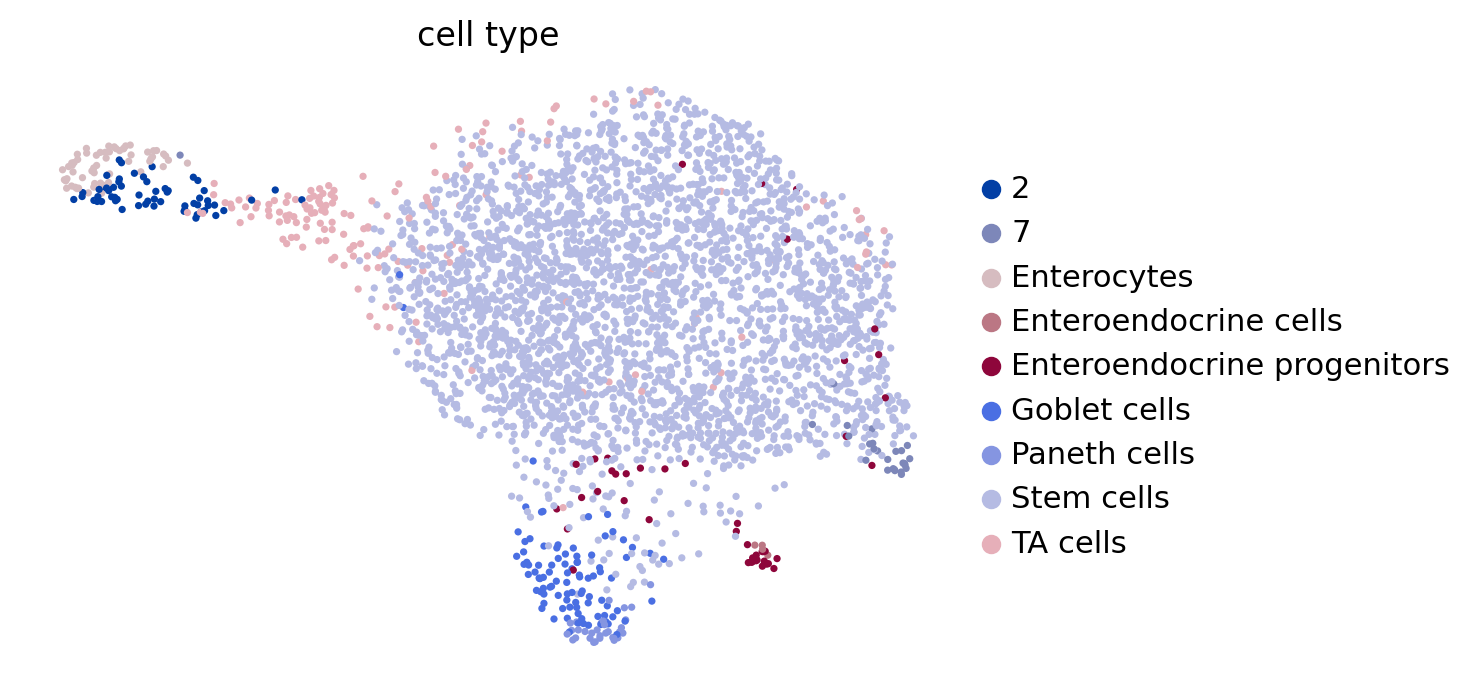

In [8]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Velocity estimation

In [9]:
alpha = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "alpha.csv", index_col=0)
alpha.index = alpha.index.astype(str)
adata.layers["transcription_rate"] = alpha.loc[adata.obs_names, adata.var_names]

gamma = pd.read_csv(DATA_DIR / "sceu_organoid" / "results" / "gamma.csv", index_col=0)
gamma.index = gamma.index.astype(str)
adata.layers["degradation_rate"] = alpha.loc[adata.obs_names, adata.var_names]

adata.layers["velocity_labeled"] = (alpha - gamma * adata.layers["labeled_smoothed"]).values

## Pseudotime construction

In [10]:
vk = cr.kernels.VelocityKernel(adata, xkey="labeled_smoothed", vkey="velocity_labeled").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=2.4573`


  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:04)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [11]:
dpt = DPT(adata=adata, neighbors_key="neighbors")
dpt._transitions_sym = get_symmetric_transition_matrix(combined_kernel.transition_matrix)
dpt.compute_eigen(n_comps=15, random_state=0)

adata.obsm["X_diffmap"] = dpt.eigen_basis
adata.uns["diffmap_evals"] = dpt.eigen_values

    eigenvalues of transition matrix
    [1.0024191  0.98475575 0.9499719  0.9143363  0.90075344 0.87188613
     0.8576526  0.81567115 0.7717359  0.76253957 0.74204767 0.7327005
     0.72588813 0.7087067  0.6973775 ]


In [12]:
adata.uns["iroot"] = 2899  # See dpt.ipynb
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [13]:
adata.obs.rename({"dpt_pseudotime": "velocity_pseudotime"}, axis=1, inplace=True)

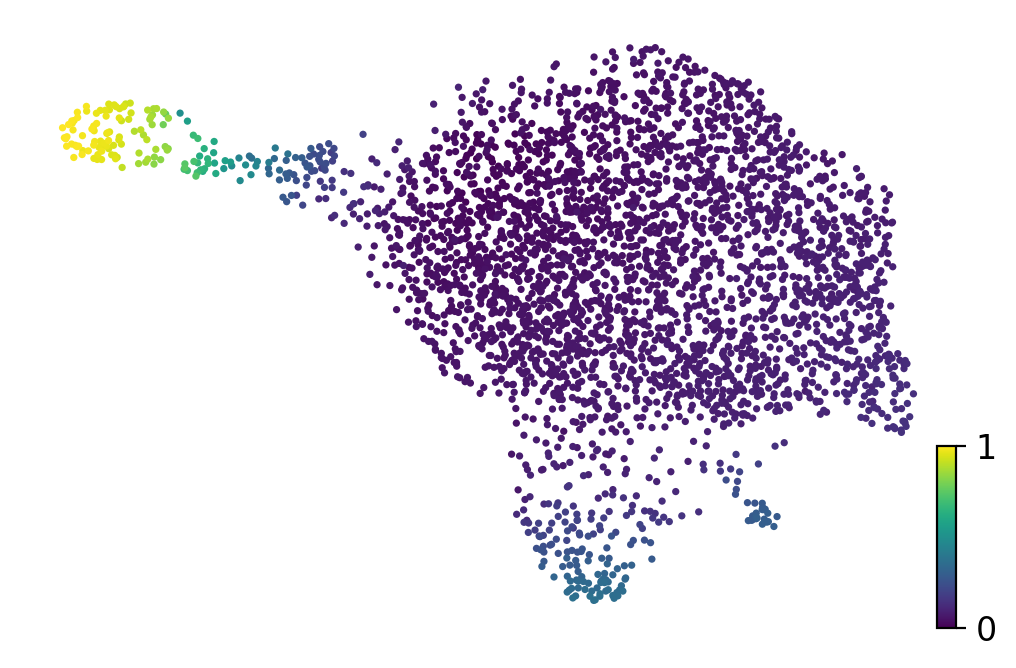

In [14]:
if running_in_notebook():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis="umap", color="velocity_pseudotime", title="", color_map="viridis", ax=ax)

if SAVE_FIGURES:
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(
        adata, basis="umap", color="velocity_pseudotime", title="", color_map="viridis", colorbar=False, ax=ax
    )
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "umap_colored_by_velocity_pseudotime.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

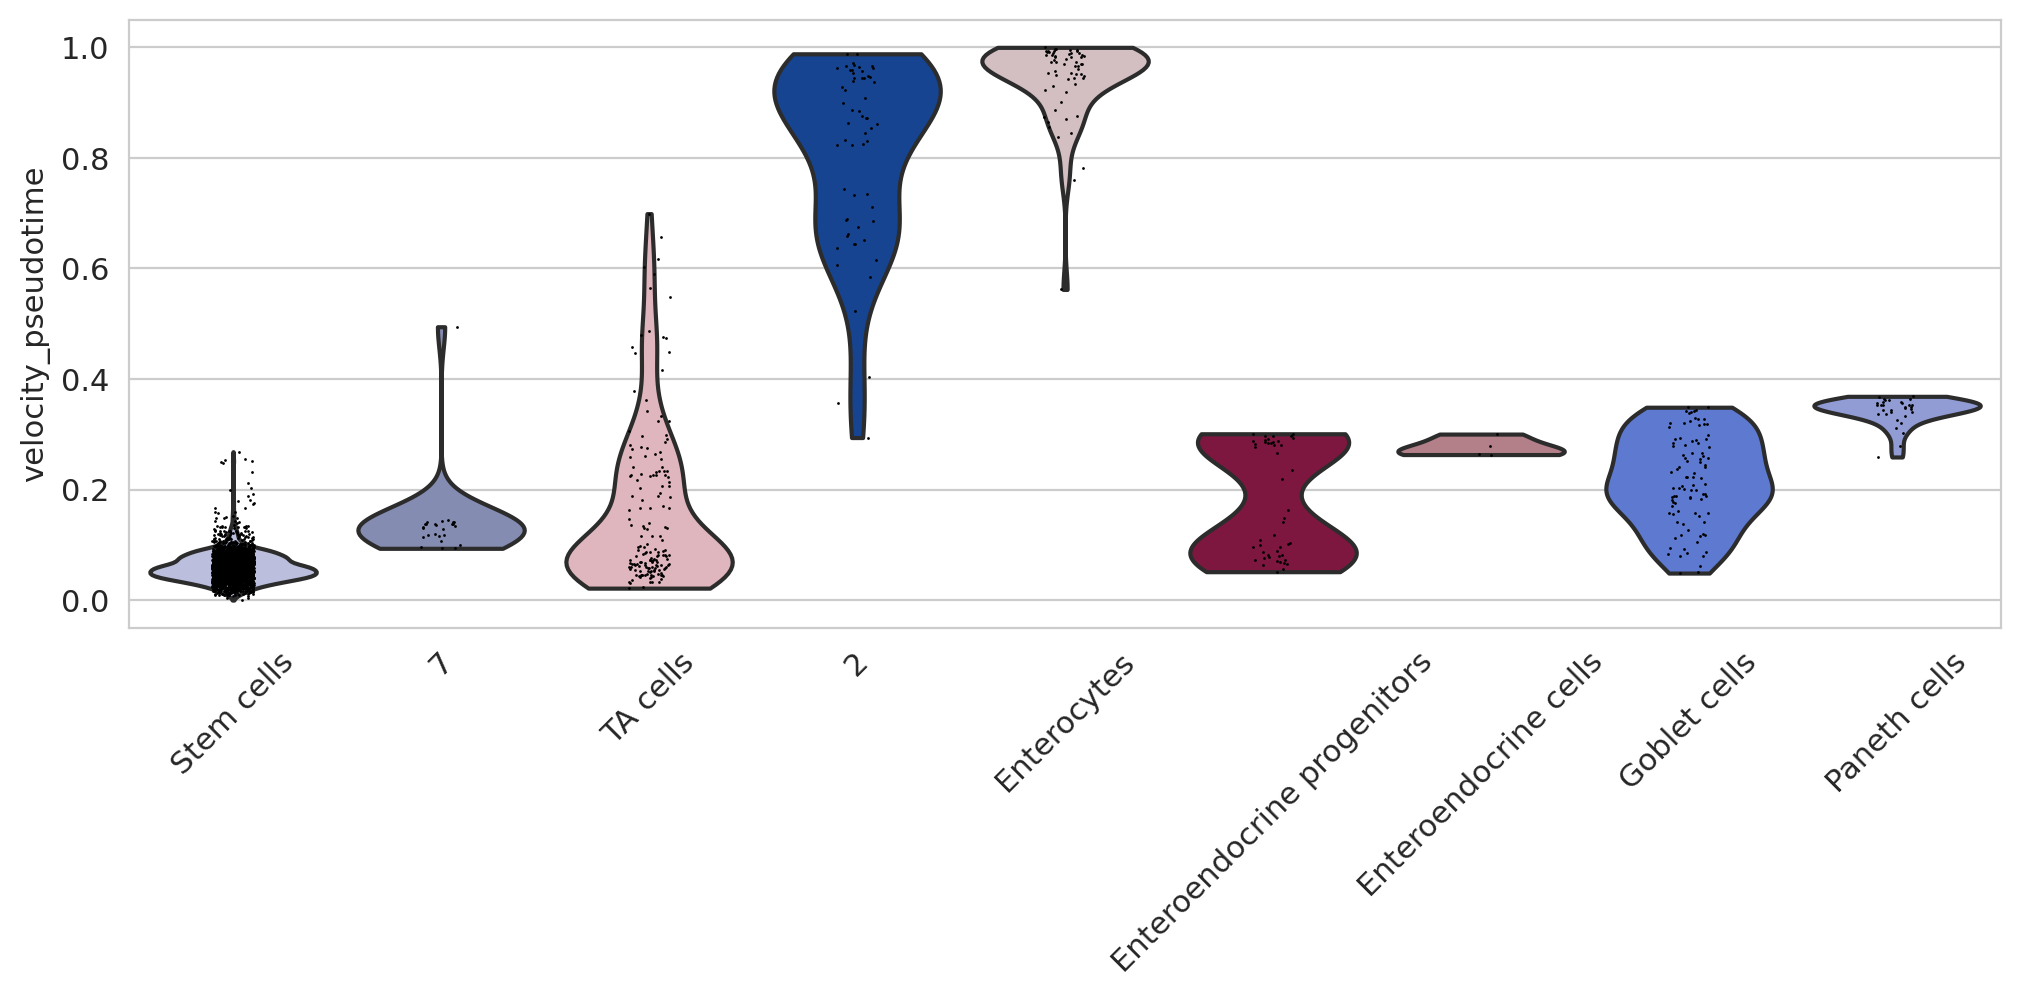

In [15]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["velocity_pseudotime"],
        groupby="cell_type",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Enteroendocrine cells",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "velocity_pseudotime_vs_cell_type.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

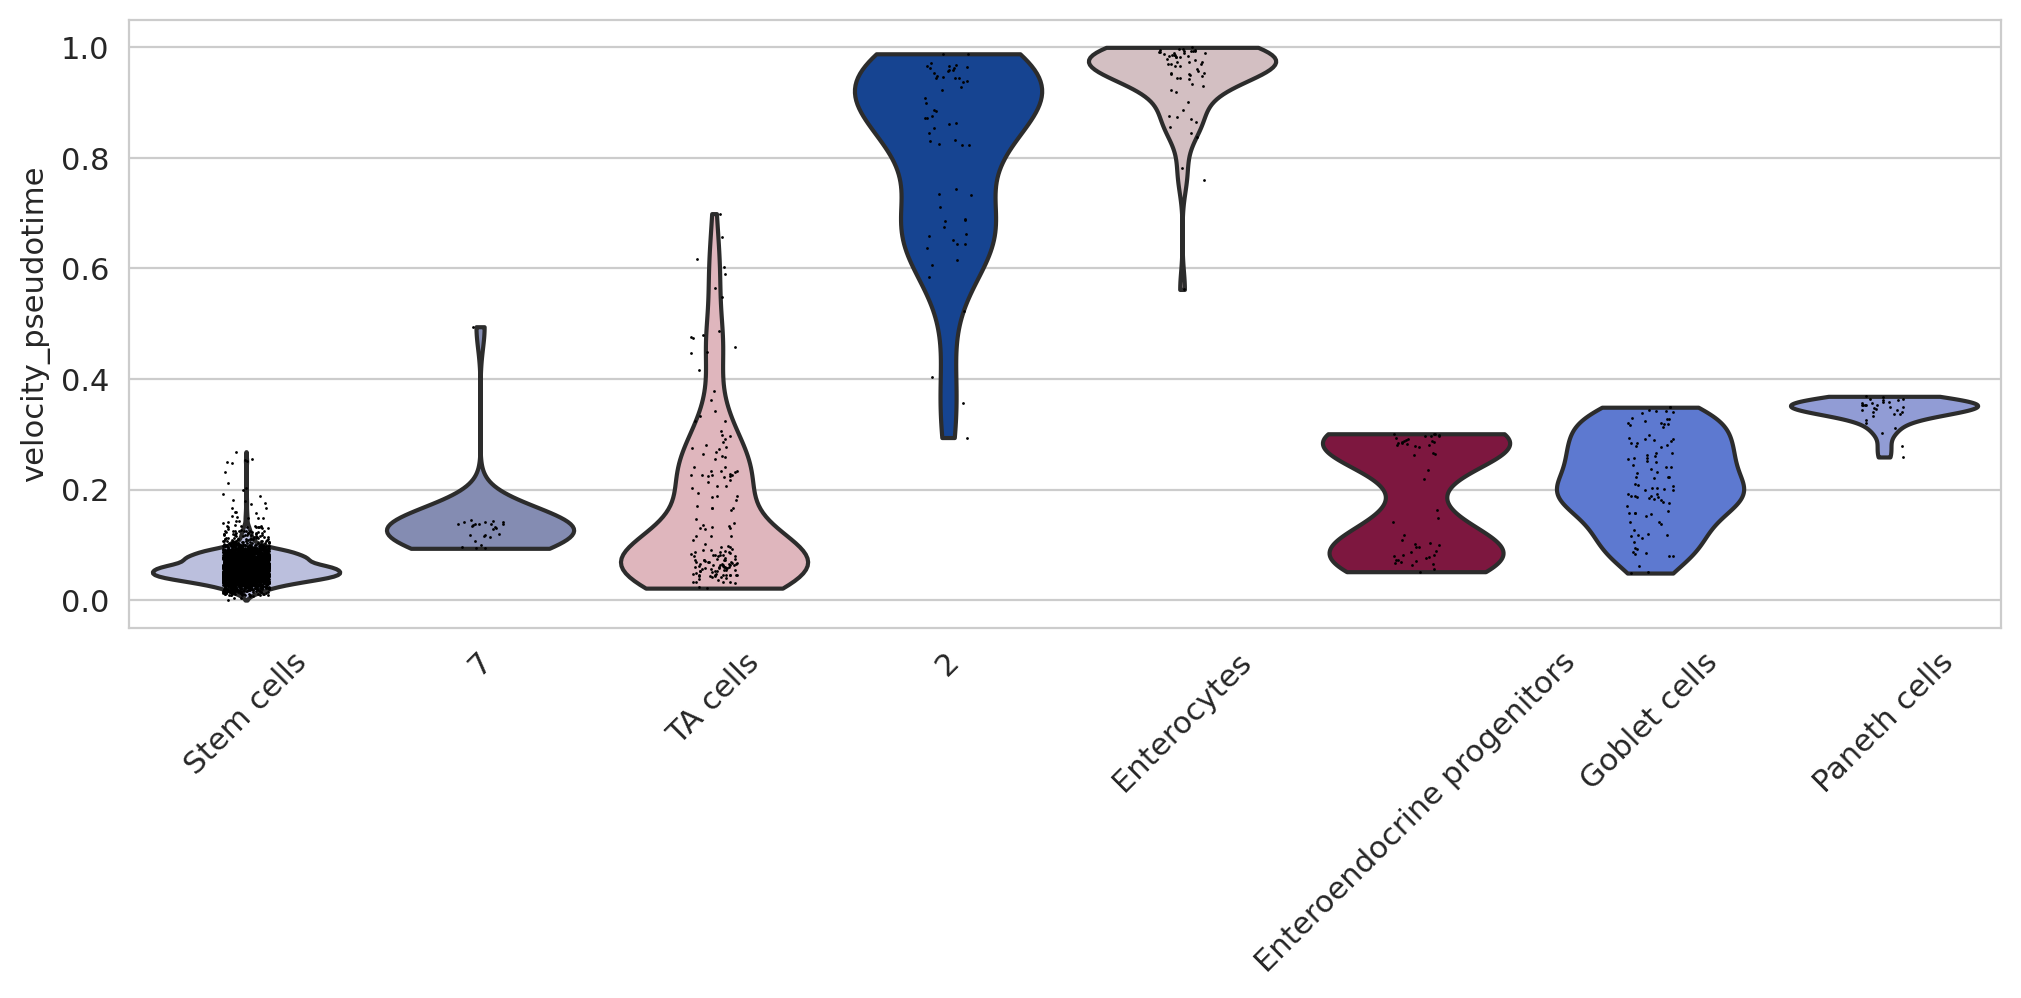

In [16]:
if running_in_notebook():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(12, 4))
    sc.pl.violin(
        adata,
        keys=["velocity_pseudotime"],
        groupby="cell_type_merged",
        rotation=45,
        title="",
        legend_loc="none",
        order=[
            "Stem cells",
            "7",
            "TA cells",
            "2",
            "Enterocytes",
            "Enteroendocrine progenitors",
            "Goblet cells",
            "Paneth cells",
        ],
        ax=ax,
    )

if SAVE_FIGURES:
    ax.set(xticklabels=[])
    fig.savefig(
        FIG_DIR / "labeling_kernel" / "velocity_pseudotime_vs_cell_type_merged.eps",
        format="eps",
        transparent=True,
        bbox_inches="tight",
    )

In [17]:
adata.obs["velocity_pseudotime"].to_csv(DATA_DIR / "sceu_organoid" / "results" / "velocity_pseudotime.csv")